# ABA Predictions Models Preliminary Results

**Several general notes about the results before jumping into the notebook**
* The first model attempts to create a faccimile of the paper [here](https://finkelsteinlab.org/assets/pdfs/0053-2019-BioRxiv-Jones%20et%20al.pdf)
* The second model attempts to predict binding purely from min energy levels of the RNA (exploiting its secondary structure) using ViennaRNA values. What is really interesting is how much predictive power this one variable has!
* The third model is a combination of the first two models since they are likely independent of each other
* Accuracy analysis is still undeveloped since we need to discuss what we should do with outlier points, I don't know enough to just throw those away. Also what and how is kd uncertainty measured?

## Model 1
*This model uses linear combinations of the features (pos, type, target) where these tuples represent the modifications to the "perfect" sequence. Pos is the position in the RNA sequence, type is one of the {"deletion", "insertion", "replacement"). Target is what the new base is (either from insertion or replacement). For each position there are a total of 9 possible variables.*

In [1]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# Time to load in the data
data = pd.read_csv("data.csv")
energies = pd.read_csv("consolidated_energies.csv")

In [3]:
data.head()

,sequence,kd,kd_uncertainty,y_intercept,delta_y,count
0,CCATAGAGAGGTTTAGGCGACA,0.411732,0.077708,0.000001,69772.0,56
1,CCATAAATAGGTTATCCGCTCA,50.996896,5.568243,31137.437284,69772.0,56
2,CCATAGAAGGTTATCCGCTA,50.162063,4.509536,33937.023904,69772.0,59
3,CCATAAGAGAGGTTAGTCCGCTCA,11.020798,1.343522,26403.072224,69772.0,69
4,CCATAGAAGGTTATCCGCTC,139.873453,11.447599,29946.137330,69772.0,88


In [4]:
energies.head()

,Sequence,Vienna,MFold
0,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUAC...,-15.7,-17.60
1,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAGAGAGUGGUUAUCC...,-23.6,-20.97
2,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,-20.9,-20.10
3,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGACGGUGUAU...,-22.5,-22.80
4,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,-22.4,-23.80


In [5]:
#want to merge these two tables together on sequence
#A sequence in energies starts with same 29 bases, then has our target sequence in data,
#then ends with 32 bases
energies["sequence"] = energies.Sequence.str.slice(29, -32).str.replace("U", "T")
big_table = pd.merge(energies, data, on='sequence', how="inner")
big_table.head()

,Sequence,Vienna,MFold,sequence,kd,kd_uncertainty,y_intercept,delta_y,count
0,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUAC...,-15.7,-17.60,CCATAGAGAGGTTATACACGCTCA,0.790831,0.093048,0.000002,69772.0,55
1,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAGAGAGUGGUUAUCC...,-23.6,-20.97,CCAGAGAGTGGTTATCCGCTCA,347.795365,86.957388,33502.418634,69772.0,50
2,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,-20.9,-20.10,CCATAGATGAGGTTATCCGCGTCA,495.470571,157.266670,32910.752390,69772.0,56
3,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGACGGUGUAU...,-22.5,-22.80,CCATAGAGACGGTGTATCCGCTCA,64.645504,5.477575,32349.727336,69772.0,79
4,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,-22.4,-23.80,CCATAGAGAGGTTATCCGTTCT,48.505550,6.460368,39068.781756,69772.0,66


In [6]:
#now we want to add the ABA column to big_table
perfect_sequence = "CCATAGAGAGGTTATCCGCTCA"
PERFECT_KD = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['kd']
big_table['ABA'] = (big_table.kd/PERFECT_KD).apply(np.log)
big_table.head()

,Sequence,Vienna,MFold,sequence,kd,kd_uncertainty,y_intercept,delta_y,count,ABA
0,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUAC...,-15.7,-17.60,CCATAGAGAGGTTATACACGCTCA,0.790831,0.093048,0.000002,69772.0,55,-1.237749
1,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAGAGAGUGGUUAUCC...,-23.6,-20.97,CCAGAGAGTGGTTATCCGCTCA,347.795365,86.957388,33502.418634,69772.0,50,4.848536
2,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,-20.9,-20.10,CCATAGATGAGGTTATCCGCGTCA,495.470571,157.266670,32910.752390,69772.0,56,5.202429
3,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGACGGUGUAU...,-22.5,-22.80,CCATAGAGACGGTGTATCCGCTCA,64.645504,5.477575,32349.727336,69772.0,79,3.165840
4,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,-22.4,-23.80,CCATAGAGAGGTTATCCGTTCT,48.505550,6.460368,39068.781756,69772.0,66,2.878600


In [7]:
#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output

In [8]:
#sample output
print(get_diff("abcdef", "bckefg"))

[(0, 'delete'), (3, 'replace', 'k'), (5, 'insert', 'g')]


In [9]:
# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables


def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
# to help analyze results
def display(predicted, actual):
    plt.scatter(predicted, actual)
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title("predicted vs actual")
    plt.show()

In [10]:
#now we build the table that we will use for regressions
#think of data_matrix as input and output variable as output
seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
output = np.array(list(seq_aba_pairs.values()))
data_matrix = []
for seq in seq_aba_pairs:
    #print(seq, perfect_sequence)
    coords = get_diff(perfect_sequence, seq)
    row = [0 for i in range(9*len(perfect_sequence))]
    for coord in coords:
        row[get_position(coord)] = 1
    data_matrix.append(row)
data_matrix = np.array(data_matrix)

In [11]:
#lets try a rudimentary linear regression on the data
#why is this not the best idea? We know that data_matrix is a low-rank matrix
#which means that there is a tendancy to overfit (PCA projection or SVD could be future work)
reg = linear_model.LinearRegression()
reg.fit(data_matrix, output)
#take a look at the coefficients
reg.coef_

array([-1.90797139e-01,  3.95363984e-01,  7.49812729e-01,  6.65332139e-01,
        2.95300629e-01,  5.96906653e+12,  1.70610977e+00,  9.53390381e-01,
       -1.06192784e+00,  1.25122299e-01, -1.28985263e+13,  1.25541435e+00,
        1.55406457e-01,  7.50116432e-01, -1.45606265e+13,  1.92018664e+00,
       -1.73811954e+00,  3.04735983e+00, -3.17506812e+13, -1.22832686e+00,
        1.94842352e+00,  4.80116360e-01, -1.43973123e+13, -8.34211102e+12,
        1.72374720e+00,  6.30957668e-01,  5.08660517e-01,  2.13995685e-01,
        1.02668642e+00,  7.54263454e-01,  3.02158800e+13,  7.99361260e-01,
        1.58334530e+13,  9.98046875e-01, -3.69372979e+13,  1.06640625e+00,
        7.67793552e+12,  7.05810547e-01,  6.73339844e-01, -7.03125000e-02,
       -2.14707046e+13,  1.58988692e+12,  1.20019531e+00,  5.83984375e-01,
        1.55078125e+00,  1.24023438e-01,  9.94140625e-01, -8.93149548e+12,
        1.14721680e+00,  8.98437500e-01, -3.23308267e+13,  6.99645996e-01,
        5.69824219e-01,  

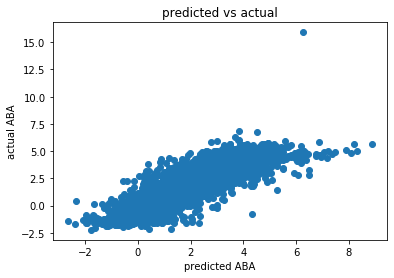

In [12]:
#how well are we predicting values?
display(data_matrix @ reg.coef_ + reg.intercept_, output)

**Right away we see that there is a section of outliers and a main section. Linear regression could be overfitting to the outliers. This can be approached with robust regression (below)**

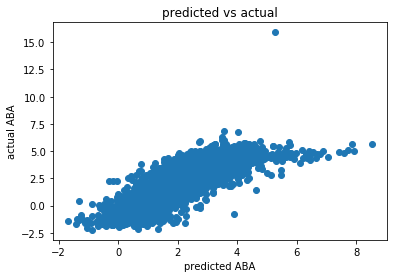

In [13]:
#before robust regression, we use ridge regression to try to minimize 
#overweighting of our linearly dependent set of rows
reg = linear_model.Ridge(alpha=20)
reg.fit(data_matrix, output)
reg.coef_

#this graph is a little close to y=x for the first blob
display(data_matrix @ reg.coef_ + reg.intercept_, output)

**A good ML technique for dealing with corrupted data could help here (as we can clearly see that there is a set of outliers. A Huber regression is perfect here because outliers only contribute linear loss. It works better than linear regression in certain cases as shown [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_huber_vs_ridge.html). Future work could be using a cooler robust regression technique called alternating robust minimization**

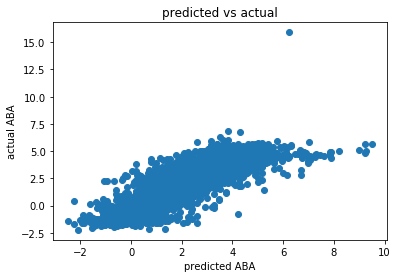

In [14]:
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(data_matrix, output)
huber.coef_
#note how the regression gets tighter for the non-outlier points
display(data_matrix @ huber.coef_ + huber.intercept_, output)

## Model 2
*This model uses the insight that lower energy of rna means that it is more unfurled (more likely to bind with the compliment rna. What this means is that there should be a correlation between this value and ABA rates. We now look into this hypothesis*

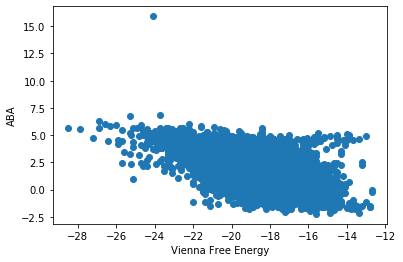

In [15]:
#before even going into modeling lets plot. Once again note the outlier group
plt.scatter(big_table.Vienna, big_table.ABA)
plt.xlabel('Vienna Free Energy')
plt.ylabel('ABA')
plt.show()

In [16]:
reg = linear_model.Ridge(alpha=5)
reg.fit(np.array(big_table.Vienna).reshape(-1,1), output)
reg.coef_

array([-0.01390065])

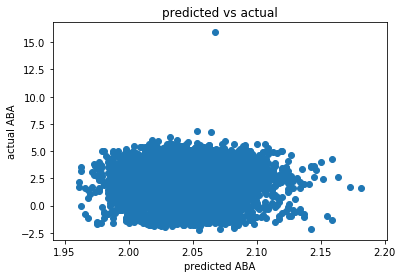

In [17]:
#here we can see the outliers above really hurting the performance of the regression
# The linear coefficiant is practically non-existatnt above
display(big_table.Vienna * reg.coef_ + reg.intercept_, output)

In [18]:
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(np.array(big_table.Vienna).reshape(-1,1), big_table.ABA)
huber.coef_

array([-0.43581911])

In [19]:
#Here is the much more logical coefficient of ~ -.5 linear relationship between the data

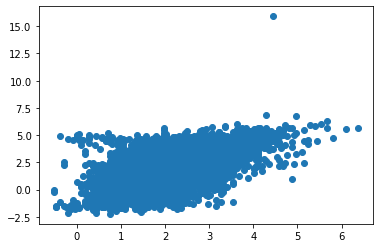

In [20]:
plt.scatter(big_table.Vienna * huber.coef_ + huber.intercept_, big_table.ABA )

## Model 3
*This model combines the more or less features from models 1 and 2 to give us a better correlation*

In [21]:
#same as the matrix code above but we add the feature of energies
combined_data_matrix = []
for seq in seq_aba_pairs:
    #print(seq, perfect_sequence)
    coords = get_diff(perfect_sequence, seq)
    row = [0 for i in range(9*len(perfect_sequence))]
    for coord in coords:
        row[get_position(coord)] = 1
    #append the value of the energy levels
    row.append(big_table[big_table['sequence'] == seq].iloc[0]['Vienna'])
    combined_data_matrix.append(row)
    
    
combined_data_matrix = np.array(combined_data_matrix)

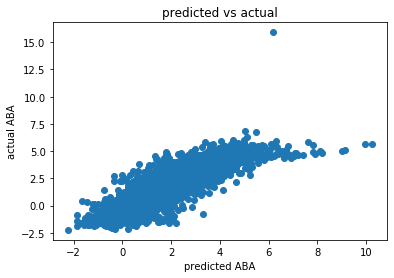

In [22]:
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(combined_data_matrix, output)
huber.coef_
#This looks like the tightest regression so far
display(combined_data_matrix @ huber.coef_ + huber.intercept_, output)

### TODO, we want to calculate r values for the non-outlier points. This requires outlier classification which we should be discussed

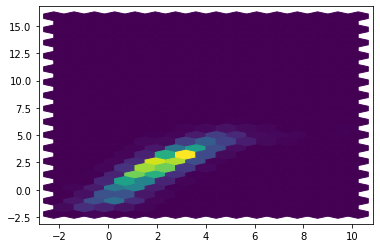

In [23]:
plt.hexbin(combined_data_matrix @ huber.coef_ + huber.intercept_, output, gridsize=(15,15) )
plt.show()


In [47]:
#same as the matrix code above but we add the feature of energies
pruned_combined_data_matrix = []
pruned_output = []
for seq in seq_aba_pairs:
    #print(seq, perfect_sequence)
    if seq_aba_pairs[seq] < 6:
        pruned_output.append(seq_aba_pairs[seq])
        coords = get_diff(perfect_sequence, seq)
        row = [0 for i in range(9*len(perfect_sequence))]
        for coord in coords:
            row[get_position(coord)] = 1
        #append the value of the energy levels
        row.append(big_table[big_table['sequence'] == seq].iloc[0]['Vienna'])
        pruned_combined_data_matrix.append(row)
    
    
pruned_combined_data_matrix = np.array(pruned_combined_data_matrix)
pruned_output = np.array(pruned_output)

In [67]:
def cube(x, c):
    return x**3 + c
def hinge(x):
    return min(x, 6)
vhinge = np.vectorize(hinge)

v_cube = np.vectorize(cube)

In [98]:
from sklearn import svm

clf = svm.SVR(kernel="linear", degree=3)
clf.fit(pruned_combined_data_matrix, pruned_output)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

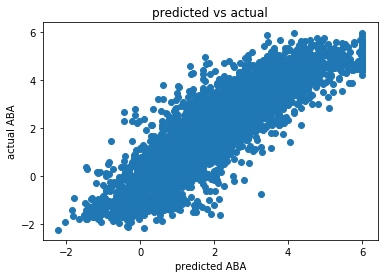

In [99]:
predicted_output = clf.predict(pruned_combined_data_matrix)
display(vhinge(predicted_output), pruned_output)

In [100]:
clf.score(pruned_combined_data_matrix, pruned_output)

0.7483538273874022

In [53]:
predicted_output = pruned_combined_data_matrix @ clf.kernel_params + clf.coef0
display(vhinge(predicted_output), pruned_output)

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [58]:
clf.score(pruned_combined_data_matrix, pruned_output)

0.7305230490317604

In [52]:
clf.kernel

['X_fit_',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_estimator_type',
 '_get_kernel',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 'alpha',
 'coef0',
 'degree',
 'dual_coef_',
 'fit',
 'gamma',
 'get_params',
 'kernel',
 'kernel_params',
 'predict',
 'score',
 'set_params']

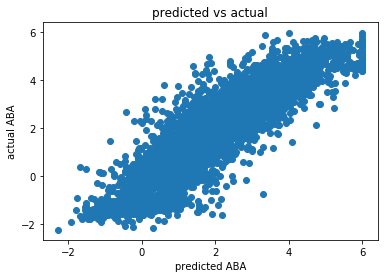

In [26]:
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(pruned_combined_data_matrix, pruned_output)
huber.coef_
#This looks like the tightest regression so far
predicted_output = pruned_combined_data_matrix @ huber.coef_ + huber.intercept_
display(vhinge(predicted_output), pruned_output)

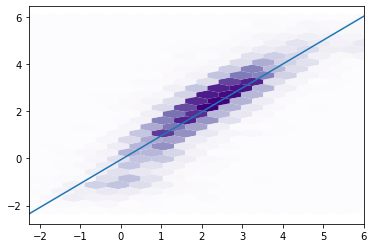

correlation is 0.875534748689374


In [27]:
plt.hexbin(vhinge(predicted_output), pruned_output, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
plt.plot(np.unique(vhinge(predicted_output)), np.poly1d(np.polyfit(vhinge(predicted_output),
                                            pruned_output, 1))(np.unique(vhinge(predicted_output))))
plt.show()
corr, p_value = pearsonr(vhinge(predicted_output), pruned_output)
print("correlation is",corr)

In [28]:
indices = np.arange(pruned_combined_data_matrix.shape[0])
np.random.shuffle(indices)
pruned_combined_data_matrix = pruned_combined_data_matrix[indices]
pruned_output = pruned_output[indices]
train_x = pruned_combined_data_matrix[:400]
test_x = pruned_combined_data_matrix[400:]
train_y = pruned_output[:400]
test_y = pruned_output[400:]

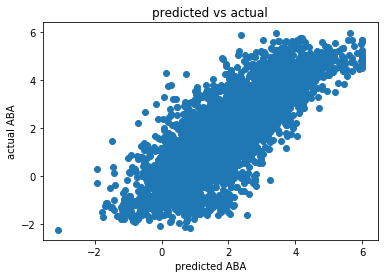

correlation is 0.796917116029513


In [29]:
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(train_x, train_y)
huber.coef_
#This looks like the tightest regression so far
predicted_output = test_x @ huber.coef_ + huber.intercept_
display(vhinge(predicted_output), test_y)
corr, p_value = pearsonr(vhinge(predicted_output), test_y)
print("correlation is",corr)

## Model 1 no outlier

In [45]:
#same as the matrix code above but we add the feature of energies
pruned_combined_data_matrix = []
pruned_output = []
for seq in seq_aba_pairs:
    #print(seq, perfect_sequence)
    if seq_aba_pairs[seq] < 6:
        pruned_output.append(seq_aba_pairs[seq])
        coords = get_diff(perfect_sequence, seq)
        row = [0 for i in range(9*len(perfect_sequence))]
        for coord in coords:
            row[get_position(coord)] = 1
        #append the value of the energy levels
        #row.append(big_table[big_table['sequence'] == seq].iloc[0]['Vienna'])
        pruned_combined_data_matrix.append(row)
    
    
pruned_combined_data_matrix = np.array(pruned_combined_data_matrix)
pruned_output = np.array(pruned_output)

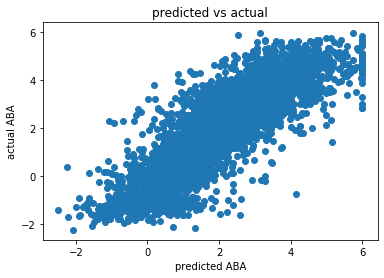

In [46]:
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(pruned_combined_data_matrix, pruned_output)
huber.coef_
#This looks like the tightest regression so far
predicted_output = pruned_combined_data_matrix @ huber.coef_ + huber.intercept_
display(vhinge(predicted_output), pruned_output)

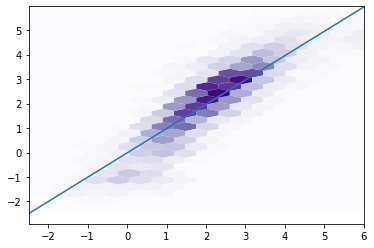

correlation is 0.841211556616347


In [32]:
plt.hexbin(vhinge(predicted_output), pruned_output, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
plt.plot(np.unique(vhinge(predicted_output)), np.poly1d(np.polyfit(vhinge(predicted_output),
                                            pruned_output, 1))(np.unique(vhinge(predicted_output))))
plt.show()
corr, p_value = pearsonr(vhinge(predicted_output), pruned_output)
print("correlation is",corr)

In [33]:
indices = np.arange(pruned_combined_data_matrix.shape[0])
np.random.shuffle(indices)
pruned_combined_data_matrix = pruned_combined_data_matrix[indices]
pruned_output = pruned_output[indices]
train_x = pruned_combined_data_matrix[:400]
test_x = pruned_combined_data_matrix[400:]
train_y = pruned_output[:400]
test_y = pruned_output[400:]

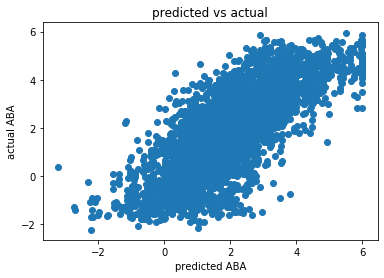

correlation is 0.7560504899394412


In [34]:
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(train_x, train_y)
huber.coef_
#This looks like the tightest regression so far
predicted_output = test_x @ huber.coef_ + huber.intercept_
display(vhinge(predicted_output), test_y)
corr, p_value = pearsonr(vhinge(predicted_output), test_y)
print("correlation is",corr)

# Model 2

In [35]:
#same as the matrix code above but we add the feature of energies
pruned_combined_data_matrix = []
pruned_output = []
output_df = []
for seq in seq_aba_pairs:
    #print(seq, perfect_sequence)
    if seq_aba_pairs[seq] < 6:
        pruned_output.append(seq_aba_pairs[seq])
        row = [(big_table[big_table['sequence'] == seq].iloc[0]['Vienna'])]
        pruned_combined_data_matrix.append(row)
        output_df.append([seq,row[0],seq_aba_pairs[seq]])
    
    
pruned_combined_data_matrix = np.array(pruned_combined_data_matrix)
pruned_output = np.array(pruned_output)

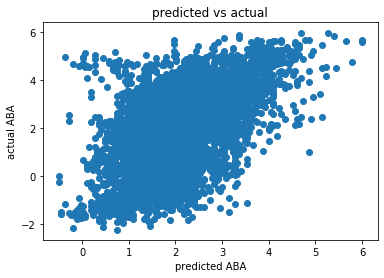

In [36]:
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(pruned_combined_data_matrix, pruned_output)
huber.coef_
#This looks like the tightest regression so far
predicted_output = pruned_combined_data_matrix @ huber.coef_ + huber.intercept_
display(vhinge(predicted_output), pruned_output)

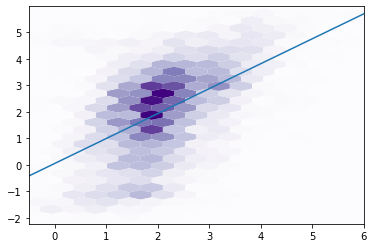

correlation is 0.5220306469574244


In [37]:
plt.hexbin(vhinge(predicted_output), pruned_output, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
plt.plot(np.unique(vhinge(predicted_output)), np.poly1d(np.polyfit(vhinge(predicted_output),
                                            pruned_output, 1))(np.unique(vhinge(predicted_output))))
plt.show()
corr, p_value = pearsonr(vhinge(predicted_output), pruned_output)
print("correlation is",corr)

In [38]:
reg = linear_model.LinearRegression()
reg.fit(pruned_combined_data_matrix, pruned_output)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

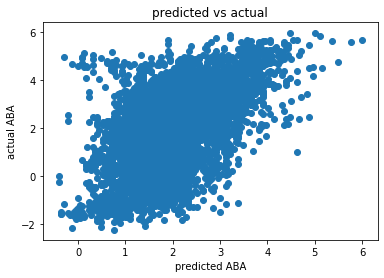

In [39]:
predicted_output = pruned_combined_data_matrix @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), pruned_output)

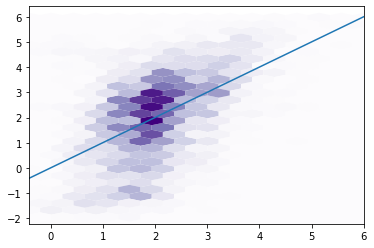

correlation is 0.5220205641517387


In [40]:
plt.hexbin(vhinge(predicted_output), pruned_output, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
plt.plot(np.unique(vhinge(predicted_output)), np.poly1d(np.polyfit(vhinge(predicted_output),
                                            pruned_output, 1))(np.unique(vhinge(predicted_output))))
plt.show()
corr, p_value = pearsonr(vhinge(predicted_output), pruned_output)
print("correlation is",corr)

In [41]:
pruned_output

array([1.90986017, 2.978599  , 3.06178742, ..., 3.07201082, 4.16390931,
       2.0861749 ])

In [42]:
output_df = pd.DataFrame(output_df, columns=['seq', 'energy', 'aba'])

In [43]:
output_df.head()

,seq,energy,aba
0,AAATAGAGAGGTTATCCGCTCA,-18.200001,1.909860
1,ACAAAGAGAGGTTATCCGCTCA,-18.200001,2.978599
2,ACACAGAGAGGTTATCCGCTCA,-18.200001,3.061787
3,ACAGAGAGAGGTTATCCGCTCA,-18.799999,2.677500
4,ACATAAAGAGGTTATCCGCTCA,-17.100000,2.732725


In [44]:
output_df.to_csv("Vienna_Energies_ABA.csv", index=False)